# Introduction to Quant Finance

## Module 1.7: Kalman Filters 

### 1.7.2 Kalman Filters Examples

In this module we will look at some examples of using Kalman filters in practice. We'll also start using a library for computing the Kalman filter, as it provides a more robust option than our roll-your-own solution from the previous notebook. While using a library is no guarantee that the code will be bug free, many libraries have significant effort put into their development, giving us a better likelihood of them having fewer bugs than our own code.

Let's start with a straight-forward example, which is predicting stock prices with a Kalman filter. We are going to choose a stock with a long history and a seemingly stable price, and our theory is going to be that the stock is correctly valued and any major deviations will be corrected over time.


In [1]:
%run setup.ipy

In [3]:
!pip install pykalman

    100% |████████████████████████████████| 235kB 7.4MB/s ta 0:00:01
  Running setup.py bdist_wheel for pykalman ... done
  Stored in directory: /home/rob/.cache/pip/wheels/d9/e8/6a/553d9832679cb74a8434fa597c3abdb07313e40054a0adf9ac
Successfully built pykalman


In [4]:
>>> from pykalman import KalmanFilter
>>> import numpy as np
>>> kf = KalmanFilter(transition_matrices = [[1, 1], [0, 1]], observation_matrices = [[0.1, 0.5], [-0.3, 0.0]])
>>> measurements = np.asarray([[1,0], [0,0], [0,1]])  # 3 observations
>>> kf = kf.em(measurements, n_iter=5)
>>> (filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
>>> (smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)

In [6]:
smoothed_state_means

array([[-0.67441149,  0.39899312],
       [-0.81992226,  0.19109279],
       [-1.72967476,  0.29641685]])

In [7]:
smoothed_state_covariances

array([[[ 0.22959645, -0.05069643],
        [-0.05069643,  0.09444809]],

       [[ 0.72264751, -0.02814856],
        [-0.02814856,  0.25053408]],

       [[ 1.16033437,  0.11983719],
        [ 0.11983719,  0.41791538]]])

In [9]:
import quandl
import my_secrets
quandl.ApiConfig.api_key = my_secrets.QUANDL_API_KEY

In [14]:
stocks = quandl.get("WIKI/IBM")

In [17]:
close = stocks['Adj. Close']

In [24]:
movement = close.pct_change().dropna()

(-0.1, 0.1)

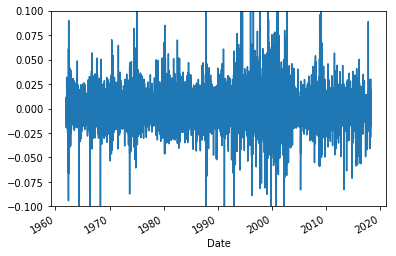

In [30]:
fig = movement.plot()
fig.set_ylim(-0.1, 0.1)  # Note there are quite a few outliers, such as a 30% drop!

In [31]:
movement.mean()  # basically 0

0.0003066222958743595

In [32]:
kf = KalmanFilter()

In [34]:
kf.em(movement)